## 1. Important building blocks for modern CNNs

Here we will study about 3 important building blocks:
* Residual connection
* Batch normalization
* Depthwise separable convolution



### Residual connections

Why do we need them? 

* CNNs can become extremely deep.
* Prone to the vanishing gradient problem

Solution:
* allow gradients to flow through another shortcut




![picture](https://drive.google.com/uc?export=view&id=1gOwZPYnxfCGSsevLCzc7_41apUrkJKI5)

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

### **Build model with residual connection**

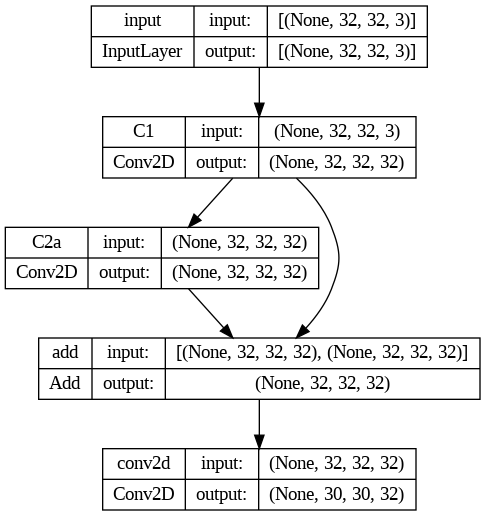

In [2]:
inputs = keras.Input(shape=(32, 32, 3), name="input")
x = layers.Conv2D(32, 3, activation="relu", padding="same", name="C1")(inputs)  # Q: No. of filters and kernel size? A: 32, 3x3
residual = x                                         
x = layers.Conv2D(32, 3, activation="relu", padding="same", name="C2a")(x)
x = layers.add([x, residual]   )   # Q: Do x and residual have the same shape? A: Yes
x = layers.Conv2D(32, 3)(x)                 
model1 = keras.Model(inputs=inputs, outputs=x)
plot_model(model1, show_shapes=True)

In [3]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 C1 (Conv2D)                    (None, 32, 32, 32)   896         ['input[0][0]']                  
                                                                                                  
 C2a (Conv2D)                   (None, 32, 32, 32)   9248        ['C1[0][0]']                     
                                                                                                  
 add (Add)                      (None, 32, 32, 32)   0           ['C2a[0][0]',                    
                                                                  'C1[0][0]']                 

Residual branch may contain 1 layer to make sure addition is possible, i.e. accomodate sizes.

In [4]:
# Build model with residual connection - layer in the residual branch

inputs = keras.Input(shape=(32, 32, 3), name="input")
x = layers.Conv2D(32, 3, activation="relu", name="C1")(inputs)  # Q: No. of filters and kernel size? 
residual = x                                         
x = layers.Conv2D(64, 3, activation="relu", padding="same", name="C2l1")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same", name="C2l2")(x)

residual = layers.Conv2D(64, 1, name="C2b")(residual)           # Q: Why 1? A: To maintain same shapes while addition
x = layers.add([x, residual]   )                      # Q: Do x and residual have the same shape?
model2 = keras.Model(inputs=inputs, outputs=x)

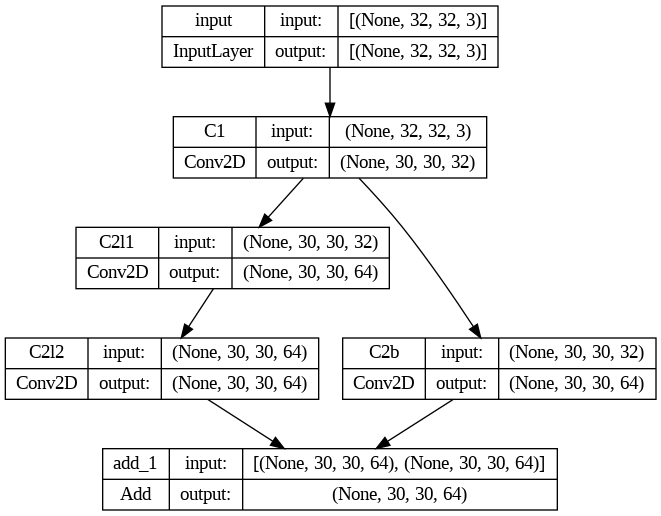

In [5]:
plot_model(model2, show_shapes=True)

In [6]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 C1 (Conv2D)                    (None, 30, 30, 32)   896         ['input[0][0]']                  
                                                                                                  
 C2l1 (Conv2D)                  (None, 30, 30, 64)   18496       ['C1[0][0]']                     
                                                                                                  
 C2l2 (Conv2D)                  (None, 30, 30, 64)   36928       ['C2l1[0][0]']                   
                                                                                            

**Important**: Add layers of **same** shape !

Q: Can we add layers of shapes (30,30,64) and (30,30,32)?

A: No

Q: But what happens if you have a pooling layer in between?

A: Spatial Dimension reduction due to stride

Solution: Use Strides in the  Conv layer in the skip connection.

### Model with residual connections and a max pool layer in between

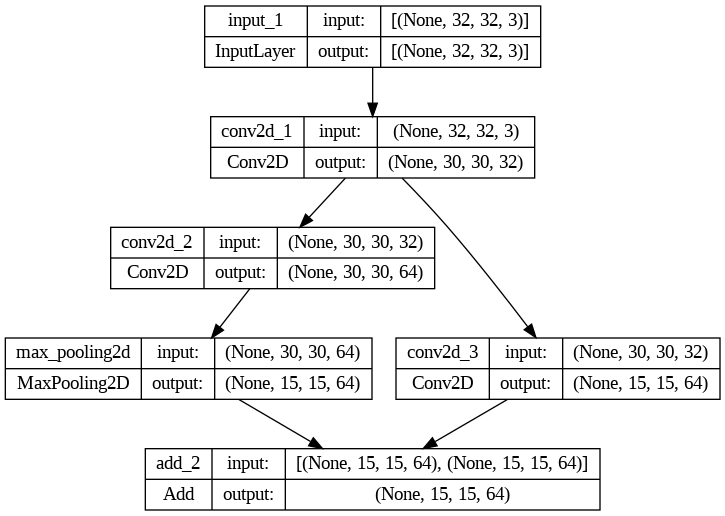

In [7]:
# model with residual connections and a max pool layer in between
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)  # Max pooling layer reduces the dimsion. #Q: By how much ? A: half
residual = layers.Conv2D(64, 1, strides=2)(residual) #Need a stride=2 to accomodate for the maxpool downsampling in the other branch
x = layers.add([x, residual])
model3 = keras.Model(inputs=inputs, outputs=x)
plot_model(model3, show_shapes=True)

In [8]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 30, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 30, 30, 64)   18496       ['conv2d_1[0][0]']               
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 15, 15, 64)   0           ['conv2d_2[0][0]']               
                                                                                            

With residual connections, you can build networks of arbitrary depth, without having to worry about vanishing gradients. We will see an example later.

**Intuitions on why residual blocks work:**
*   Shorter path for gradients
*   Easy to learn the identity matrix
*   Ensemble of shallow networks

### **Batch Normalization**
*   Adaptively normalize data even as the mean and variance change over time during training
*   During training, it uses the mean and variance of the current batch of data to normalize samples
*    During inference (when a big enough batch of representative data may not be available), it uses an exponential moving average of the batch-wise mean and variance of the data seen during training.


<div>
<img src="https://miro.medium.com/max/1153/1*xQhPvRh08oKFC63swgWr_w.png" width="500"/>
</div>

Now let's try to calculate the no. of params introduced because of batch normalization in following example.

### Model with a batch normalization layer 

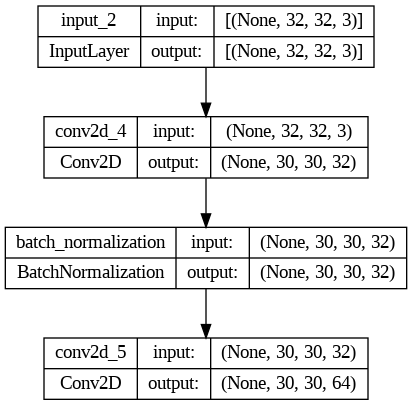

In [9]:
# Model with a batch normalization layer 
inputs = keras.Input(shape=(32, 32, 3))
# Because the output of the Conv2D layer gets normalized, the layer doesn’t need its own bias vector
x = layers.Conv2D(32, 3, activation="relu", use_bias=False)(inputs) 
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
model4 = keras.Model(inputs=inputs, outputs=x)
plot_model(model4, show_shapes=True)

Q: How many paramerters does the BN layer introduce in the above model?

A: 128


Q: HOW?

A: Batch Normalization layer introduces 4 trainable parameters per channel. Number of channels in the preceeding layers is 32. Hence, the total number of parameters is equal to 32 * 4 = 128.

In [10]:
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        864       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
Total params: 19,488
Trainable params: 19,424
Non-trainable params: 64
_________________________________________________________________


**Intuitions:**
*  Batch Normalization is also a (weak) regularization method. 
    - increases no. of params
    - but also adds noise ~ data augmentation ~ dropout

### **Depthwise separable convolutions**

* This layer performs a **spatial convolution [Depthwise Conv.]** on each channel of
its input, independently, before mixing output channels via a **pointwise convolution**.

* **Depthwise separable convolution = Depthwise Conv. +  Pointwise Conv.**

* This makes your model smaller and  acts as a strong prior. We impose a strong prior by assuming that spatial patterns and cross-channel patterns can be modeled separately.This is equivalent to separating the learning of spatial features and the learning of channel-wise features.
* Depthwise separable convolution relies on the assumption that spatial locations in intermediate activations
are highly correlated, but different channels are highly independent. So we never use depthwise separable convolution after the input layer. Because RGB channels are **highly correlated**.

<figure>
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/RGB_channels_separation.png" width="400"/><img src="https://drive.google.com/uc?export=view&id=1e4h4NdbHRCxB1Oe_eoNhQQ6ZbAERf22K" width="500"/> <figcaption>## RGB channels are highly correlated. ##________________## Depthwise separable convolutions ##</figcaption>

</center>
</figure>


Let's quickly look at the code first

In [11]:
# Building a model with Separable Conv layer
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs) 
x = layers.SeparableConv2D(64, 3, activation="relu", padding="same")(x)
sep_model = keras.Model(inputs=inputs, outputs=x)
plot_model(sep_model, show_shapes=True)
sep_model.summary()
# Q: Verify the no. of params in the separable_conv2D layer A: (32*(3*3)) + (32*1*1*64) + 64 = 2400
# Not in keras 'SeparableConv2D', the bias at  Depthwise Conv. is not considered.
# Considering all bias : (32*(3*3) + 32) + (32*1*1*64) + 64 = 2432

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 separable_conv2d (Separable  (None, 30, 30, 64)       2400      
 Conv2D)                                                         
                                                                 
Total params: 3,296
Trainable params: 3,296
Non-trainable params: 0
_________________________________________________________________


Let's compoare the above with a model where we replace the SeparableConv2D with a Conv2D layer.

In [12]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
model = keras.Model(inputs=inputs, outputs=x)
plot_model(model, show_shapes=True)
model.summary()
# Q: Why does sep_model have much less params? A: Depthwise and pointwise convs are done independently

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________


### **A mini Xception-like model**

We'll build a model like the Xception model, but a smaller version.

But first let's see what the actual Xception model looks like.

![picture](https://miro.medium.com/max/833/1*t6qfo9ucYza_lbLfg5-p_w.png)

Q: In middle- flow blocks, what arguments do you give to the SepConv layer ?

A: HW question


Let's download the cats-vs-dogs data again and create datasets.

In [13]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/cats_vs_dogs_small.zip
!unzip -qq '/content/cats_vs_dogs_small.zip'
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/convnet_from_scratch_with_augmentation.keras

In [14]:
# defining path names for futur use
data_dir = '/content/cats_vs_dogs_small'

train_path = data_dir + '/train'
validation_path = data_dir + '/validation'
test_path = data_dir + '/test'

In [15]:
# creating datasets using utility
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
               train_path,
                image_size=(180, 180), # Resize the images to (180,180) 
                batch_size=32)
validation_dataset = image_dataset_from_directory(
                      validation_path,
                      image_size=(180, 180),
                      batch_size=32)
test_dataset = image_dataset_from_directory(
                test_path,
                image_size=(180, 180),
                batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [16]:
import keras
from keras import layers
inputs = keras.Input(shape=(180, 180, 3))
# x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x) # Q: why not use depth-wise sep conv here? A: RGB channels in input image are highly corelated

for size in [32, 64, 128, 256, 512]:                # Repeated block. Very common practice
    residual = x

    x = layers.BatchNormalization()(x)              # We can also apply BN just before the activation
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

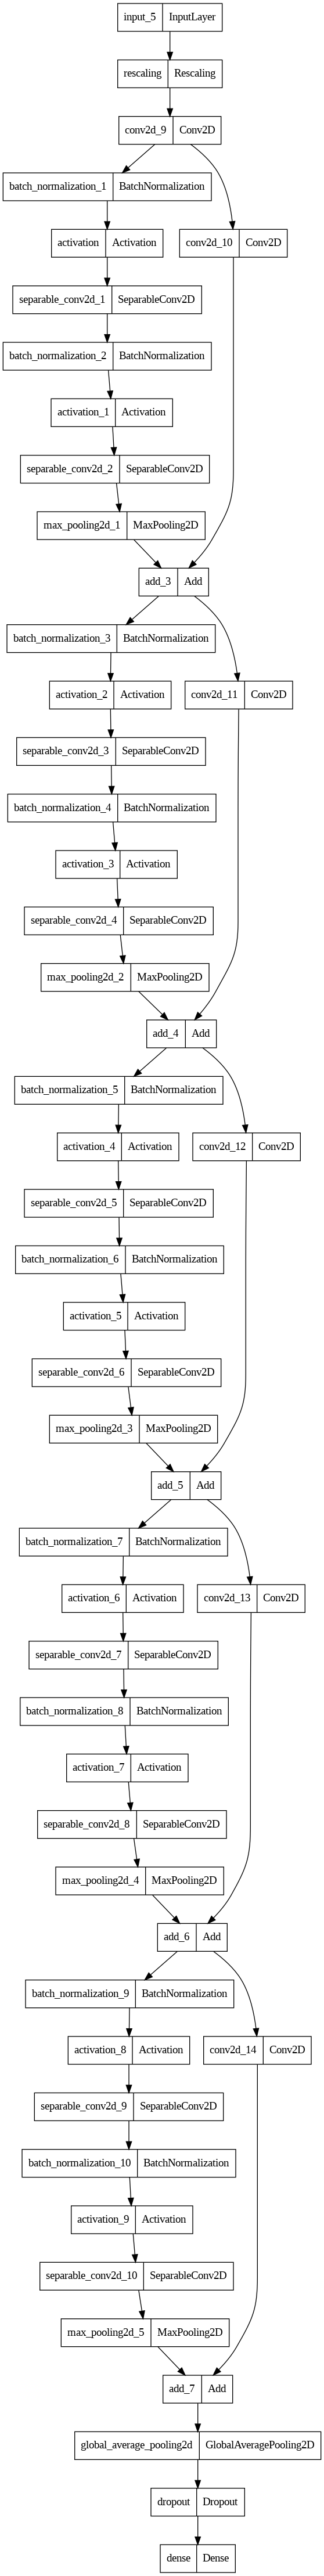

In [17]:
plot_model(model)

In [18]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
history = model.fit( train_dataset,
                      epochs=100,
                      validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 30s 178ms/step - loss: 0.7105 - accuracy: 0.5670 - val_loss: 0.7159 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 9s 138ms/step - loss: 0.6446 - accuracy: 0.6190 - val_loss: 0.6922 - val_accuracy: 0.5240
Epoch 3/100
63/63 [==============================] - 9s 140ms/step - loss: 0.6130 - accuracy: 0.6635 - val_loss: 0.7146 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 9s 137ms/step - loss: 0.5790 - accuracy: 0.6995 - val_loss: 0.7052 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 10s 149ms/step - loss: 0.5465 - accuracy: 0.7165 - val_loss: 0.8880 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 9s 137ms/step - loss: 0.5153 - accuracy: 0.7570 - val_loss: 1.1979 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 9s 138ms/step - loss: 0.4664 - accuracy: 0.7910 - val_loss: 0.7259 - val_accuracy: 0.55

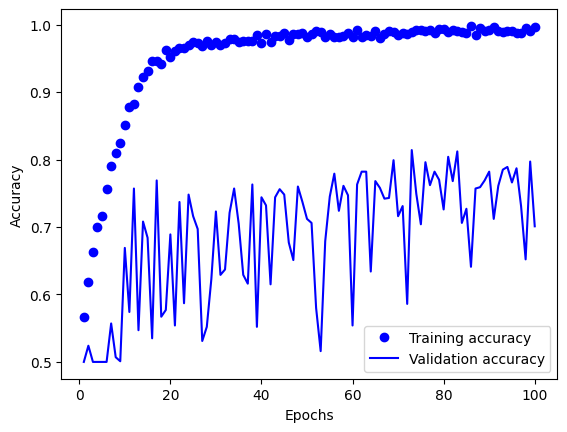

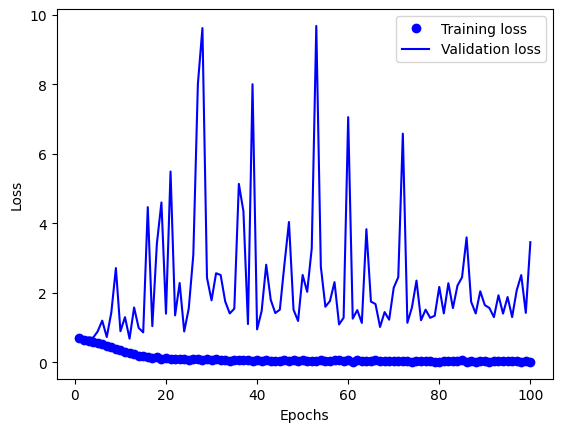

In [19]:
data = pd.DataFrame(history.history)
plt.plot(range(1,len(data)+1),data['accuracy'],'bo',label="Training accuracy")
plt.plot(range(1,len(data)+1),data['val_accuracy'],'b',label="Validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()
plt.figure()
plt.plot(range(1,len(data)+1),data['loss'],'bo',label="Training loss")
plt.plot(range(1,len(data)+1),data['val_loss'],'b',label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## 2. Interpreting what ConvNets learn
 * Visualizing intermediate ConvNetsoutputs (intermediate activations)
 * Visualizing ConvNets filters
 * Visualizing heatmaps of class activation in an image

NOTE:
* We will focus mostly on the concepts and key ideas
* A lot of the code is pre-processing and post-processing. We will not spend time on these parts.
* We will see the part of the code that implements the key ideas.

Pro:
*   Developing ideas
*   Developing thought process

### **Visualizing intermediate activations**

The output of a layer is called its 'activation'(It's the output of the activation function).

These activations can be visualized by plotting the feature maps.

![picture](https://drive.google.com/uc?export=view&id=1vT8e59AYTFRlrrI3C-iUHTctxyhfBiJJ)

We will plot each feature map independently as a 2D image, since they encode relatively indepent features.

In [20]:
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras import layers  # <----- Note this

**Model to be used for visualization :** We are going to use a trained model from the previous assignment -  M2_AST_01_Convolutional _Neural_Networks. In that assignment, we created one model with augmentation and saved it through a callback function with the name "convnet_from_scratch_with_augmentation.keras". You can download that model from there and use it by providing the proper path after loading it.

For the sake of simplicity, we have already provided that model and has been downloaded along with the dataset.

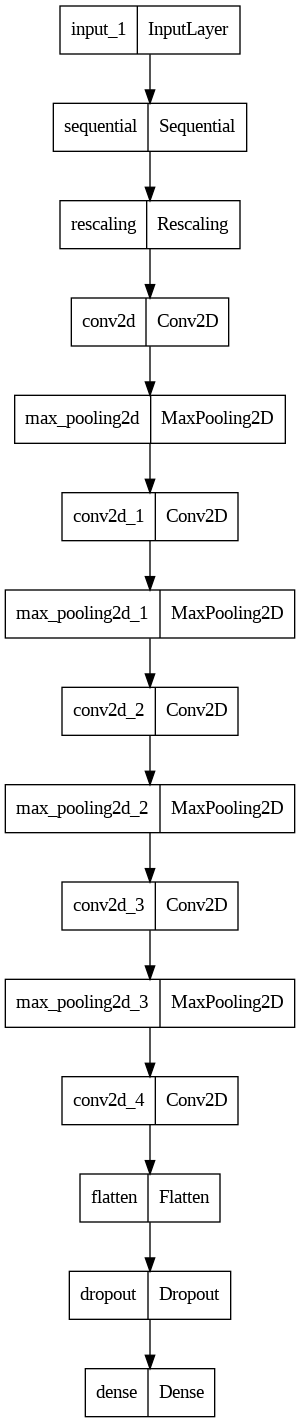

In [21]:
model = keras.models.load_model('/content/convnet_from_scratch_with_augmentation.keras')
plot_model(model)

In [22]:
test_loss, test_acc = model.evaluate(test_dataset) #Q: Why don't we have 2 arguments
print(f"Test accuracy is:{test_acc:.3f}")

63/63 [==============================] - 4s 40ms/step - loss: 0.4231 - accuracy: 0.8255
Test accuracy is:0.826


**Getting the image &  Preprocessing** that will be passsed inside the model for visualization .

80329/80329 [==============================] - 0s 0us/step


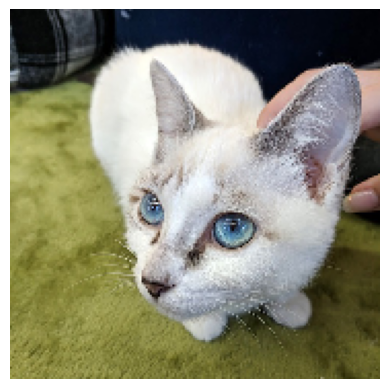

In [23]:
img_path = keras.utils.get_file(fname="cat.jpg",origin="https://img-datasets.s3.amazonaws.com/cat.jpg")
# Preprocessing a single image
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img) # converts image to np array
    # Add a dimension to transform the array intoa “batch” of a single sample. 
    array = np.expand_dims(array, axis=0)     #Its shape is now (1, 180, 180, 3)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180)) #resize image

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

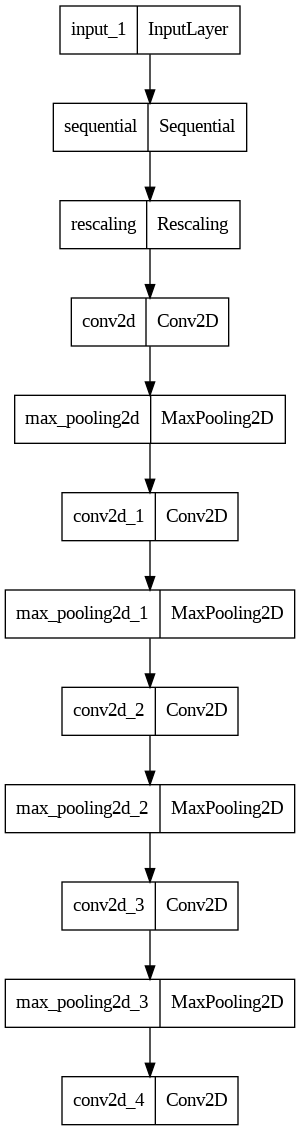

In [24]:
# Focus here
# Instantiating a model that returns "layer activations"
layer_outputs = []
layer_names = []
for layer in model.layers:                                      #Q: what does model.layers return ? A: list of layers of the model
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)): #Q: difference between layer and layers? A: layer is a layer object in the model. layers is the module we have imported
        layer_outputs.append(layer.output)
        # layer_outputs.append(layers.Dense(1)(layer.output))  # To visualise the output in plot_model()
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs) #Q: what does layer_outputs contain? A: output of conv2d and maxpool layers
plot_model(activation_model)


In [25]:
activation_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [26]:
# Compute layer activations
activations = activation_model.predict(img_tensor)
print(f"No. of outputs= {len(activations)}")

first_layer_feature_maps = activations[0]    # Q: why is this the first layer's activation? A: index 0
print(f"first_layer_activation.shape= {first_layer_feature_maps.shape}")

1/1 [==============================] - 0s 322ms/step
No. of outputs= 9
first_layer_activation.shape= (1, 178, 178, 32)


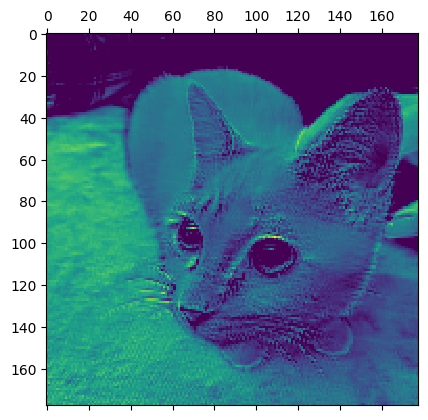

In [27]:
# Visualise activation
import matplotlib.pyplot as plt
plt.matshow(first_layer_feature_maps[0, :, :, 0], cmap="viridis")  # Q: which (1st/2nd/..)feature map are we visualing? A: 1st (0 in the last index)

It seems that the filter has detected ______.

Let's look at a feature map after each layer.

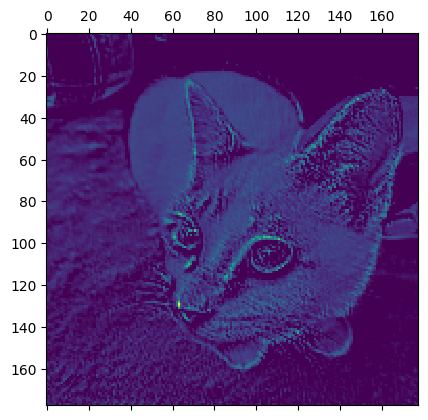

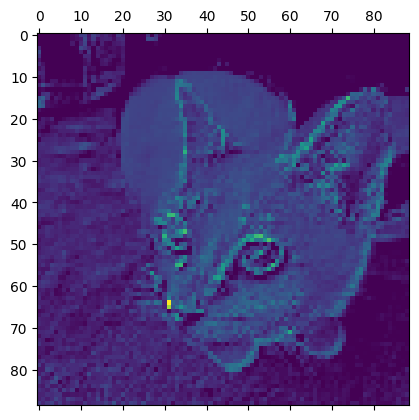

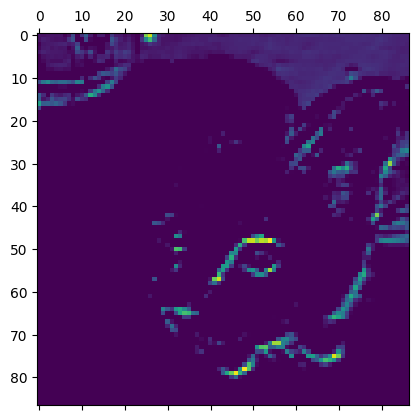

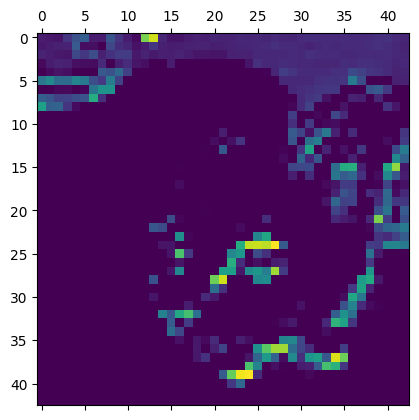

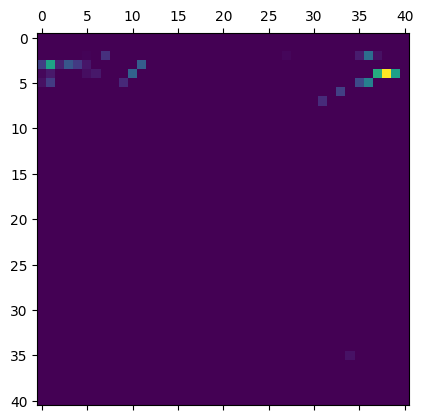

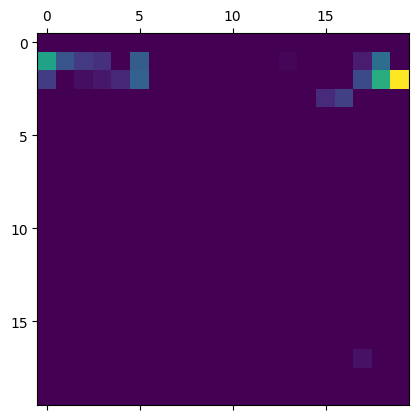

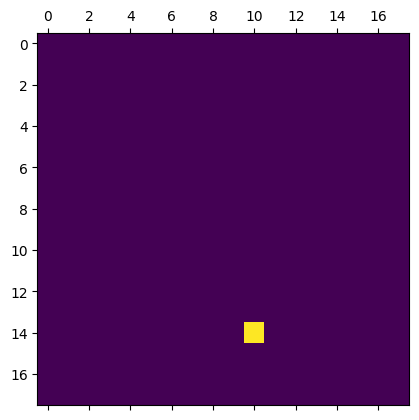

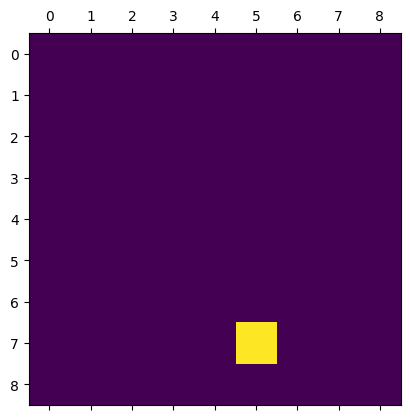

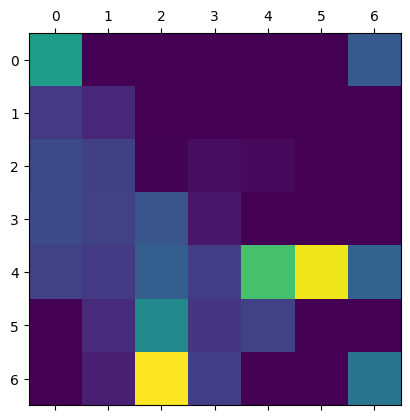

In [28]:
for i in range(9):
  plt.matshow(activations[i][0, :, :, 2], cmap="viridis")  


Note the dimensions on the above images. Successive feature maps are actually of smaller dimensions but scaled to be the same size during visualization. 

Now let's visualise all the feature maps of all the layers.

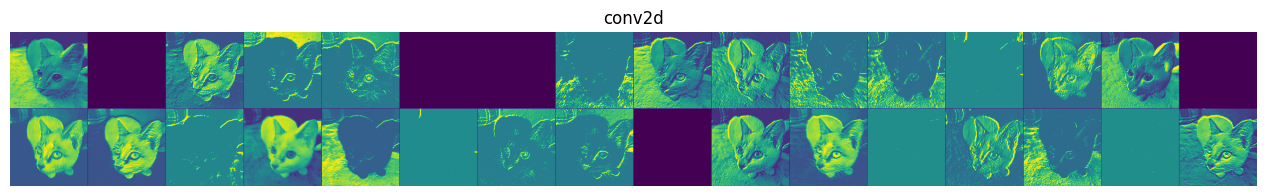

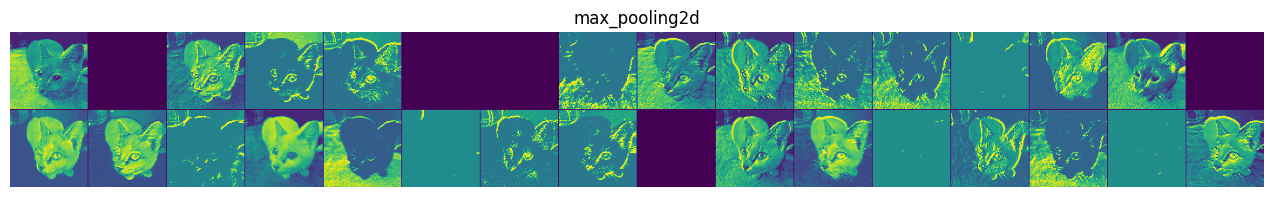

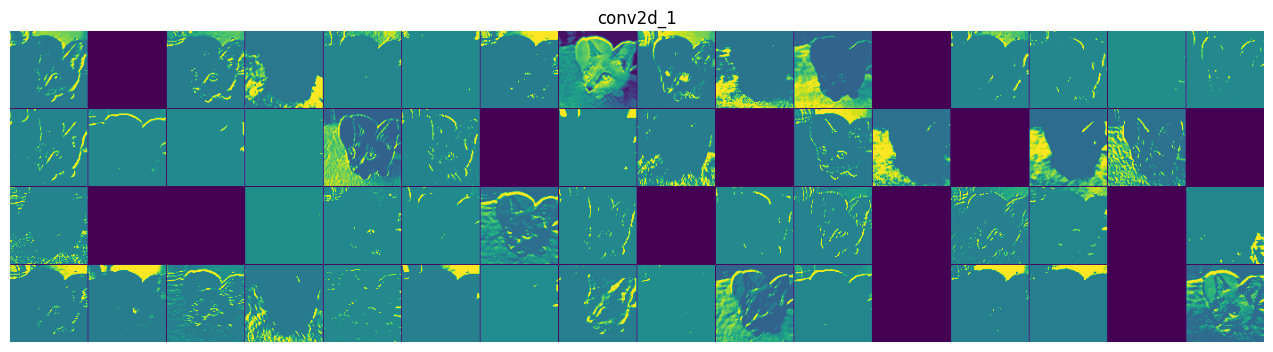

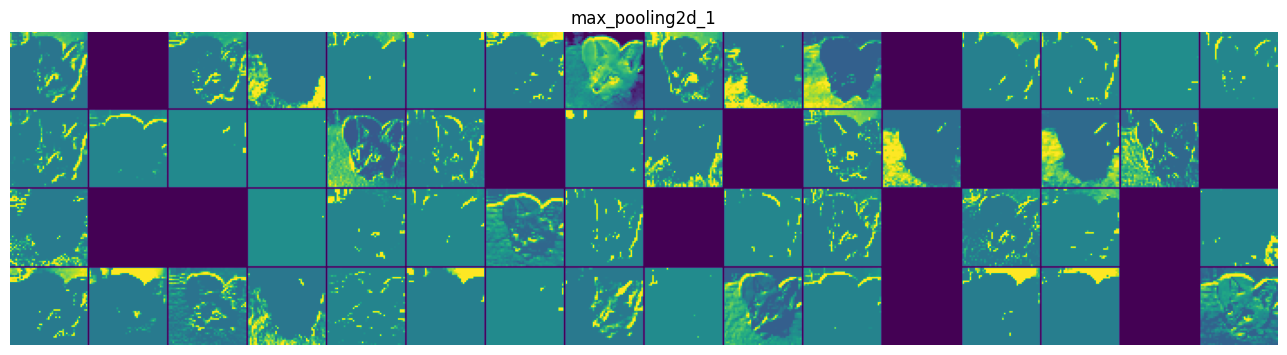

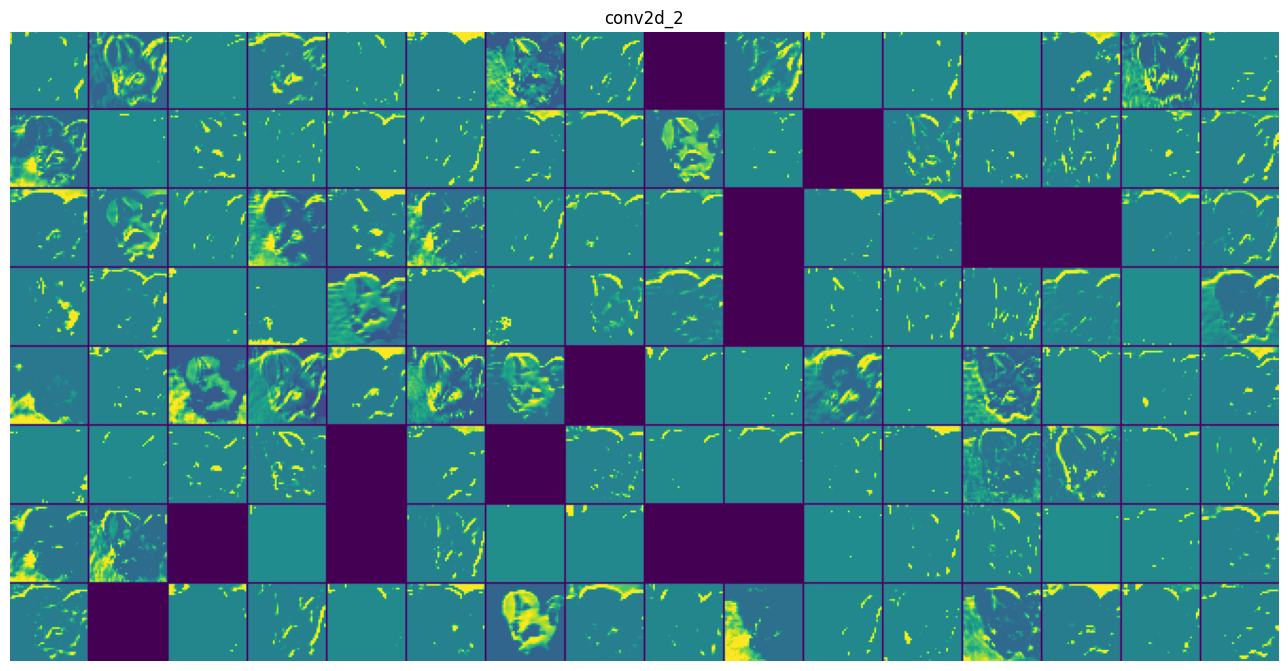

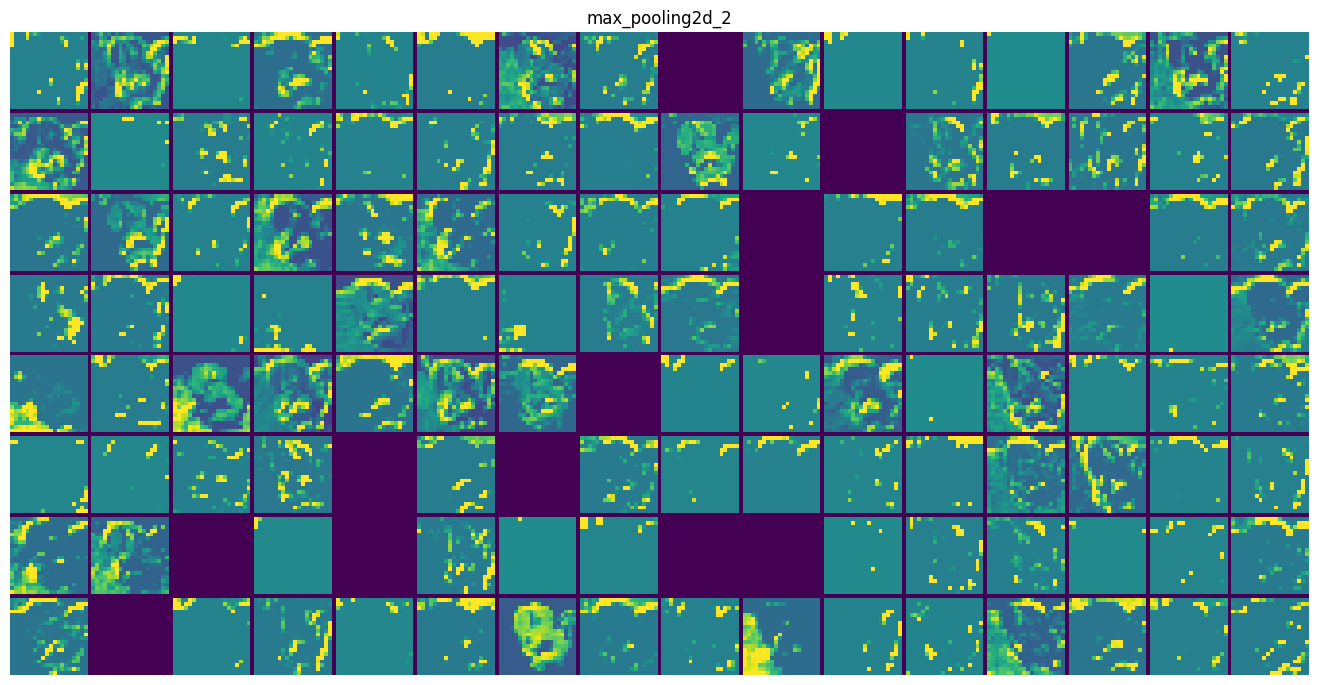

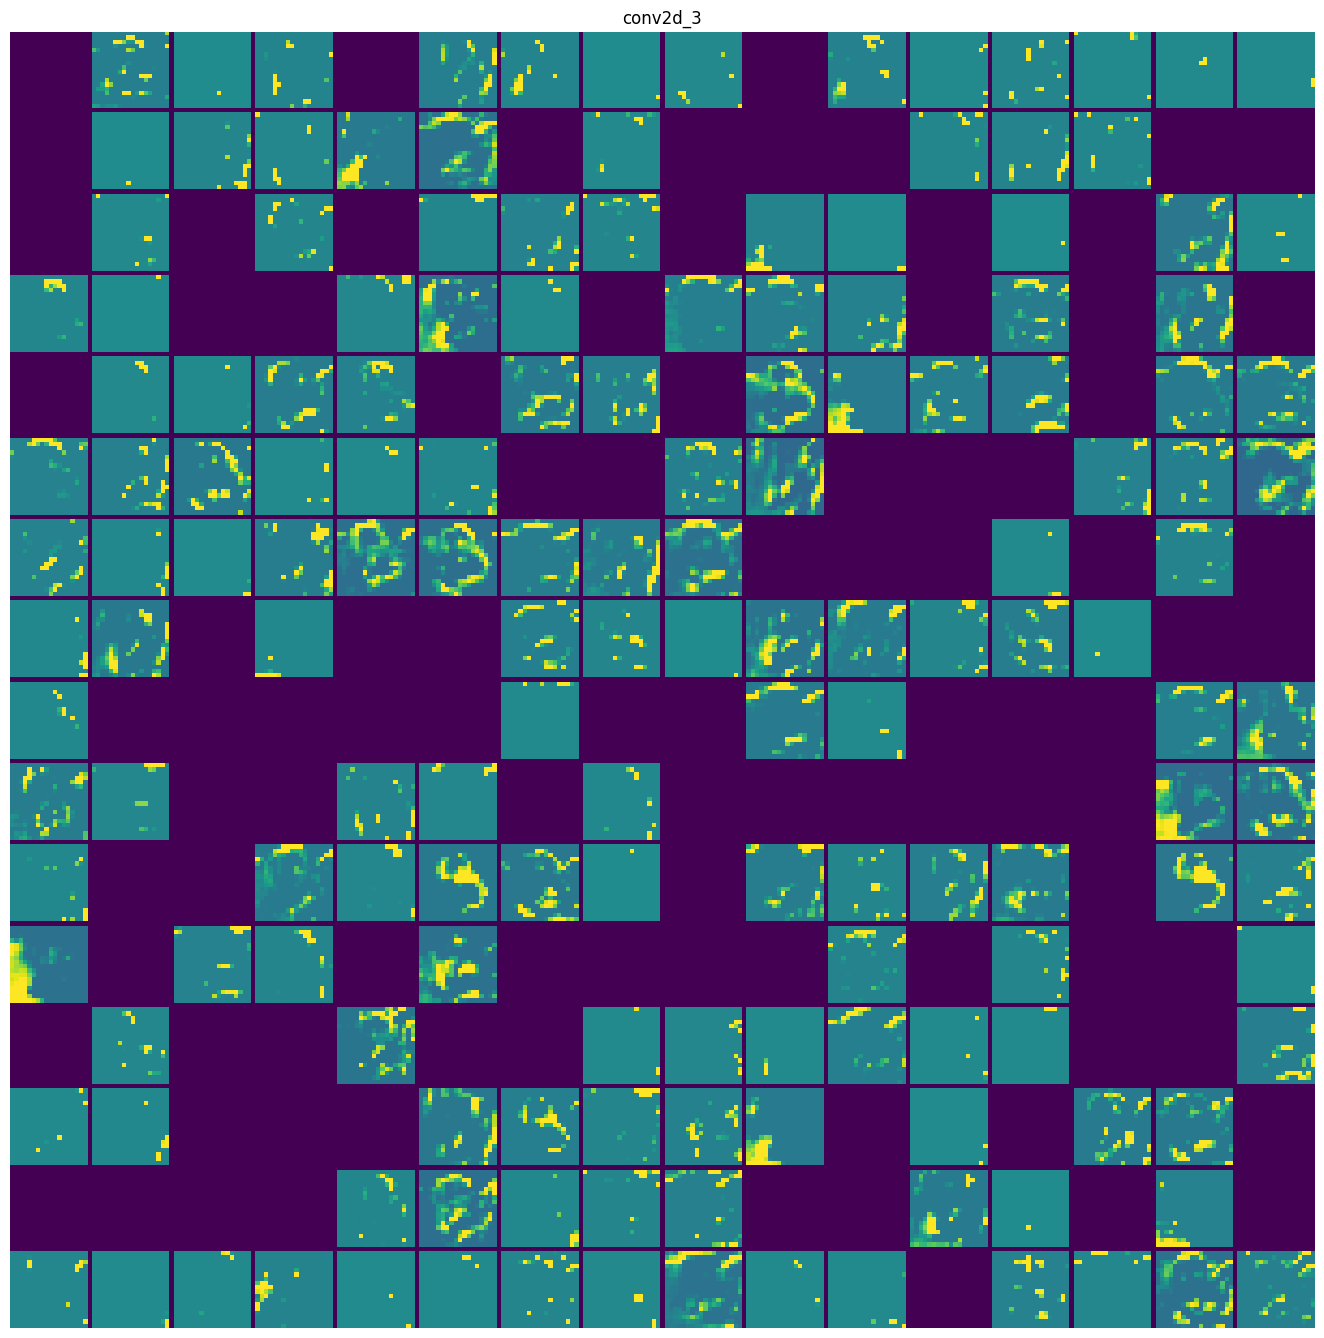

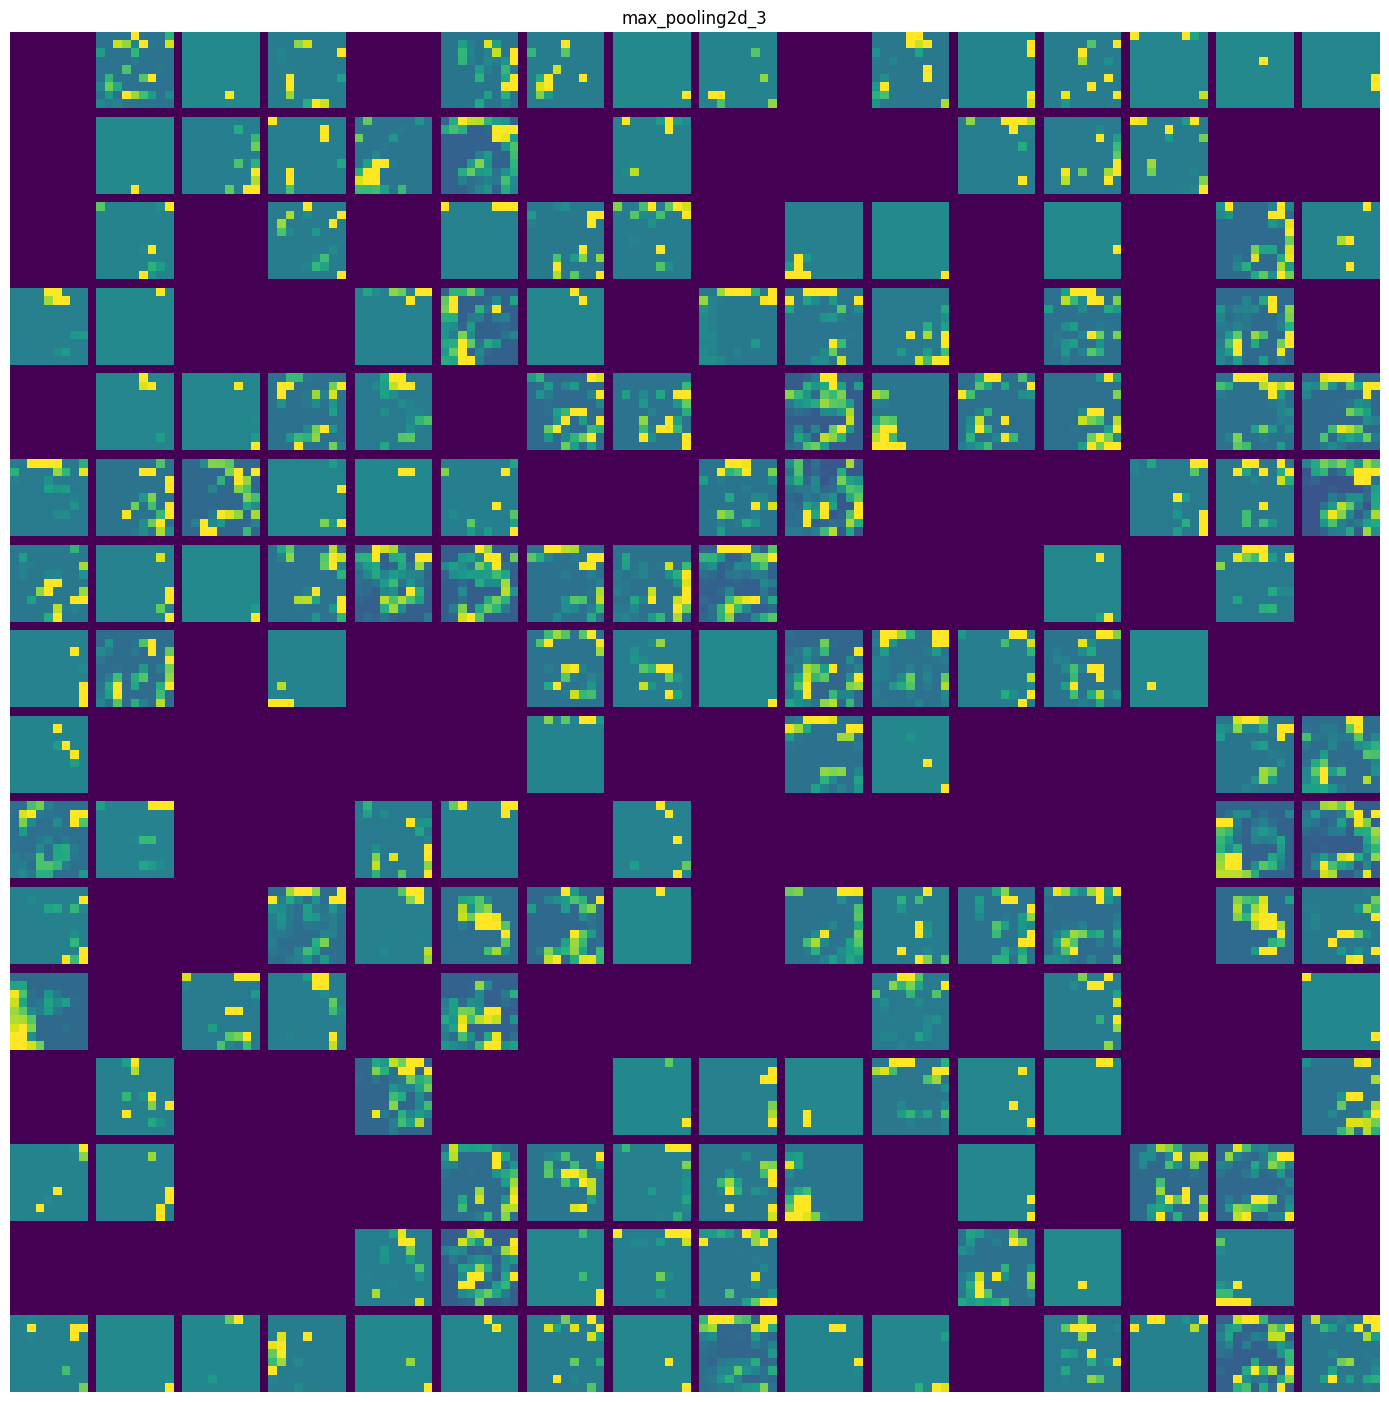

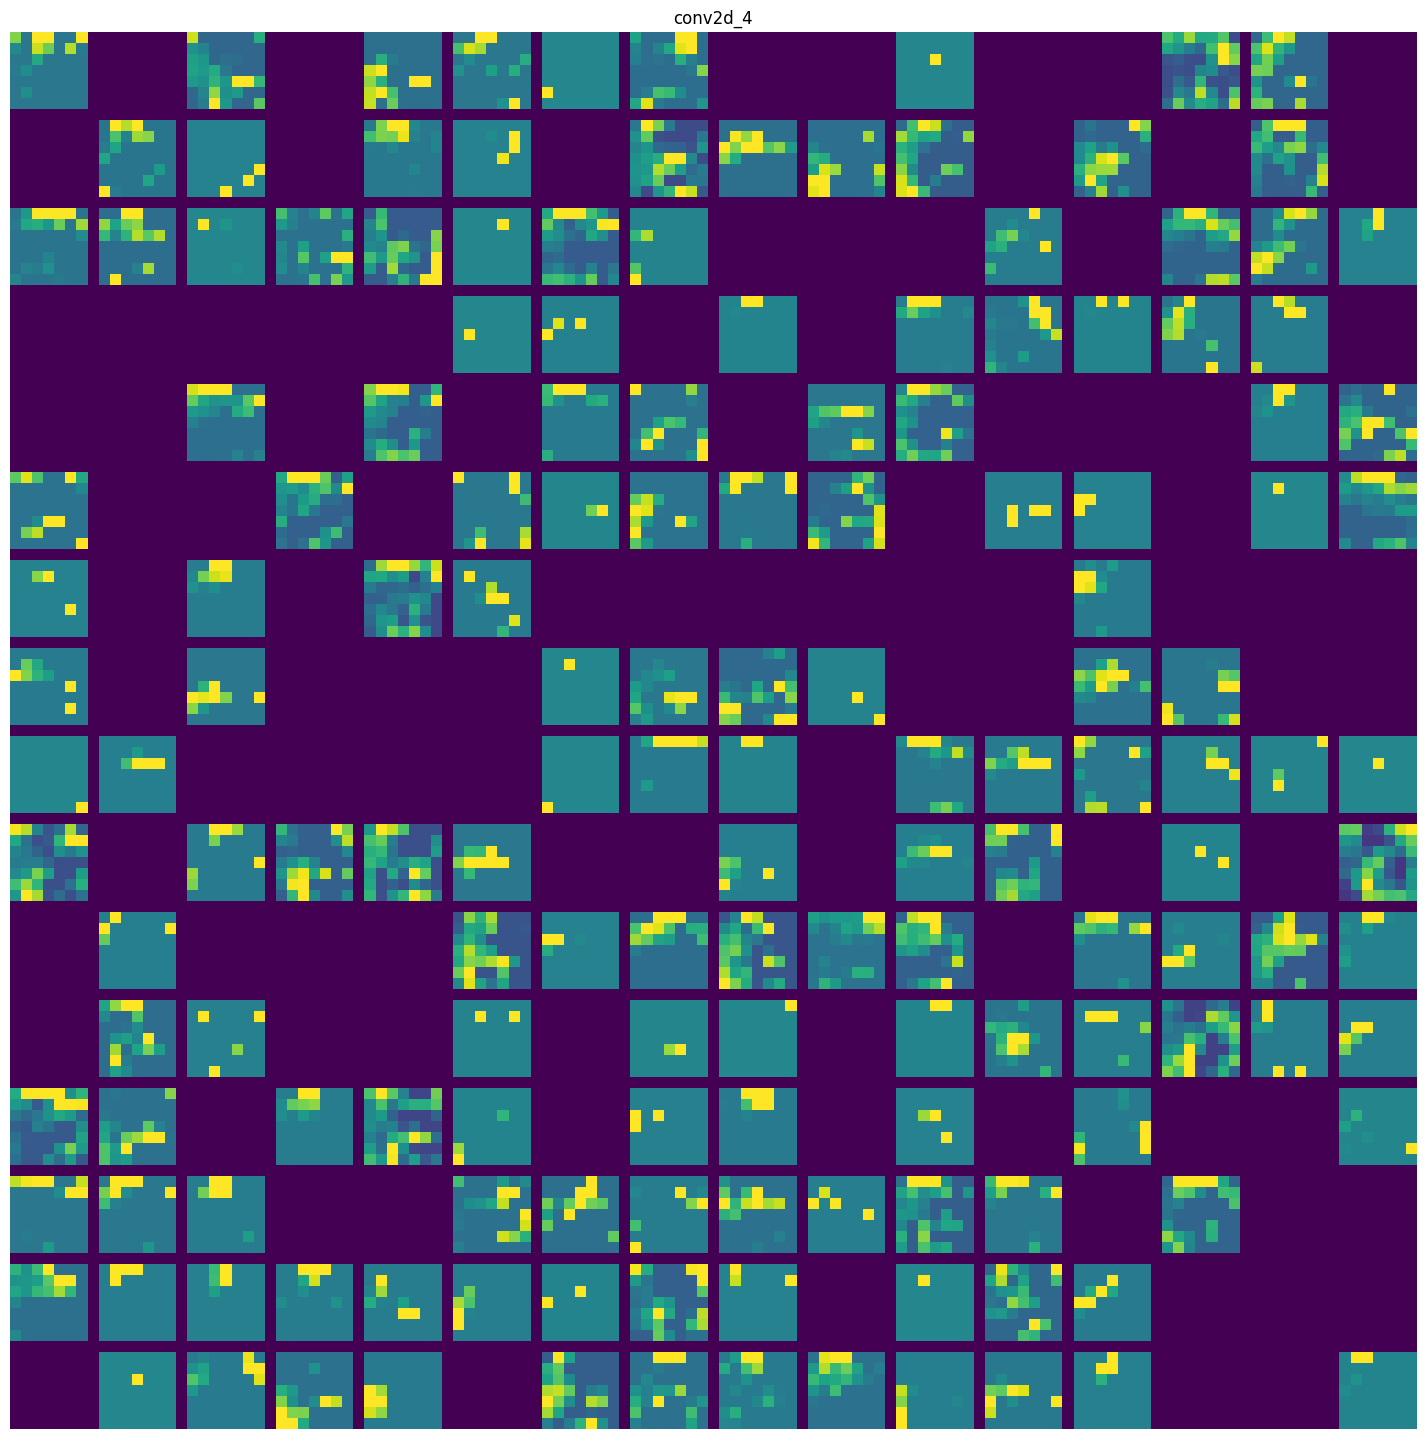

In [29]:
# Post-processing code - only visualizaton
# Visualizing every channel in every intermediate activation
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

* The first layer acts as a collection of various edge detectors.

* As you go deeper, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.”

* The sparsity of the activations increases with the depth of the layer: in the first layer, almost all filters are activated by the input image, but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image

### **Visualising ConvNet filters**
*   Pick a filter
*   Ask the question: What kind of an input image will excite the filter?
*   What should the input image be so that you see a (yellow) feature map?
*   In other words, we want to visualize those patterns in the input image that the filter picks up and results in high (yellow) values in the feature map.


In [30]:
# Instantiating the Xception convolutional base

model = keras.applications.xception.Xception( weights="imagenet", include_top=False)

83683744/83683744 [==============================] - 0s 0us/step


In [31]:
# Q: Printing the names of  conv and sepConv layers in Xception

for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_15
block3_sepconv1
block3_sepconv2
conv2d_16
block4_sepconv1
block4_sepconv2
conv2d_17
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_18
block14_sepconv1
block14_sepconv2


In [32]:
# Creating a feature extractor model

layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output) 
feature_extractor.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_6[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                         

Q: What is the last layer ?

Q: How many filters does block3_sepconv1 have?

Q: Why are there so many Nones in the shapes?

In [33]:
# Using the feature extractor

activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))
# Image is preprocessed specific to Inception model before passing inside the feature_extractor

Here comes the key idea:
*   Define an objective function: mean pixel value of feature map
*   Use gradient "Ascent" on the "input image space" to maximize this objective
Here's an analogy: (drawing)

In [34]:
import tensorflow as tf

def compute_loss(image, filter_index):      #Q: How many indices do we have? A: 256
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index] # leaving out the boundaries
    return tf.reduce_mean(filter_activation)

In [35]:
# Loss maximization via stochastic gradient ascent
# Revise tutorial 1
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)    # Q: Is the gradient a vector or scalar? A: vector
    grads = tf.math.l2_normalize(grads)    # Normalize the gradient
    image += learning_rate * grads          # Q: What makes this gradient "ascent"? A: plus sign
    return image


In [36]:
# Function to generate filter visualizations

img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

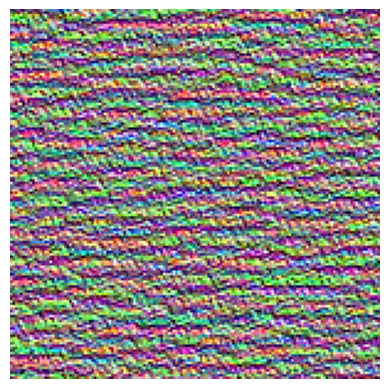

In [37]:
# Utility function to convert a tensor into a valid image

def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

In [38]:
# Post processing- Just visualization
# Generating a grid of all filter response patterns in a layer

all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

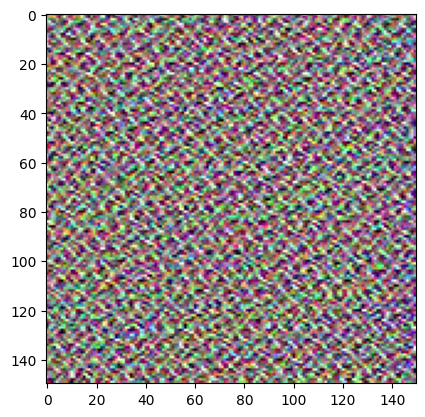

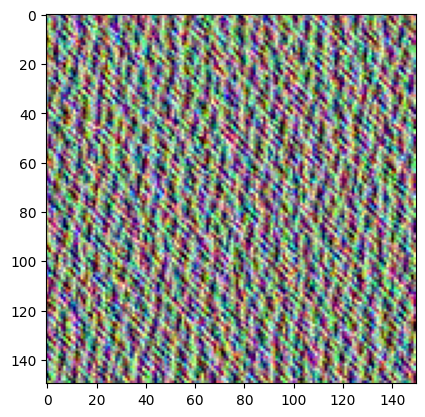

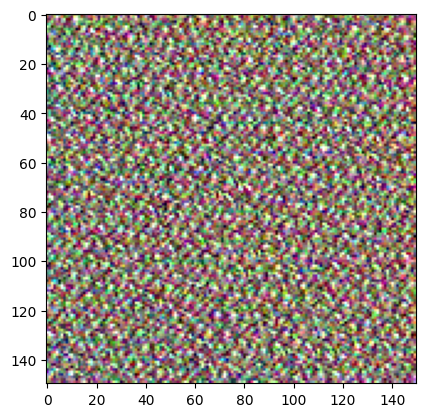

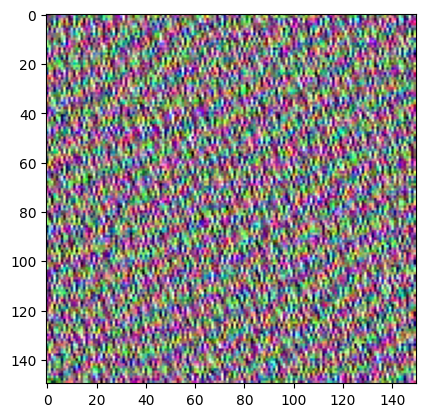

In [39]:
# plt.figure(figsize=(40,40))
# plt.matshow(stitched_filters)

for i in [0,8,16,32]:
  plt.figure()
  plt.imshow((all_images[i]))

![picture](https://drive.google.com/uc?export=view&id=1bwf3RIEp9yNTICbf1f5FWg9bX1H5BGNm)

![picture](https://drive.google.com/uc?export=view&id=1VMtNw4qCs4BoN7d9Us8tNEtiKK_J4Csd)

![picture](https://drive.google.com/uc?export=view&id=1eXCejZ3bZP1rBwtLzUQ9RMO9N0tuqDCP)



###  **Visualizing heatmaps of class activation**

* Visualise which parts of a given image led a ConvNet to its final classification decision
* Such techniques are called **class activation map** (CAM) visualisation
* Produce heatmaps of class activation over input images.

Example:

![picture](https://drive.google.com/uc?export=view&id=1z1XY2GoYq_tEXhTXNMNT9qT3Yp2ic9ZR)

First let's understand the idea behind CAM:

(Remember: The CNN is already trained. Now we are just visualising aspects of the trained CNN)




![picture](https://drive.google.com/uc?export=view&id=1-Kn8BsHj1rPr61NGdRy822o1fvQuxW3l)


Note:
*   One set of optimal weights for one class



Now let's look at an improved version of CAM:


*   Grad-CAM



![picture](https://drive.google.com/uc?export=view&id=10QgdjWzPejhmCXLvzoXpf3_ySYx2BVCj)

Key Take-away: 


*   Need the weights. Q: What are these weights?
    - make up a weighted sum of featurmaps to get a heat map 
*   Can learn them through a new sub-problem- CAM
*   Can compute them directly through gradients- grad-CAM



In [40]:
# Loading the Xception network with pretrained weights

model = keras.applications.xception.Xception(weights="imagenet")


91884032/91884032 [==============================] - 1s 0us/step


In [42]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [43]:
# Preprocessing an input image for Xception

img_path = keras.utils.get_file(fname="cat.jpg",
                                origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

In [44]:
# Predicting the top three labels
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 0us/step
[('n02123597', 'Siamese_cat', 0.6304777), ('n02127052', 'lynx', 0.15553112), ('n02124075', 'Egyptian_cat', 0.052980453)]


In [46]:
# printing out the top label
np.argmax(preds[0])


284

In [47]:
# Setting up a model that returns the last convolutional output

last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [ "avg_pool",
                            "predictions",]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
# plot_model(last_conv_layer_model)

In [48]:
last_conv_layer_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [49]:
# Reapplying the classifier on top of the last convolutional output


classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)


In [50]:
# Retrieving the gradients of the top predicted class

import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output) # this is the grad of top class wrt output feature map

![picture](https://drive.google.com/uc?export=view&id=10QgdjWzPejhmCXLvzoXpf3_ySYx2BVCj)

In [51]:
# Gradient pooling and channel-importance weighting

# take an avg of the grads - formula for w_k
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]

# multiply weights with feature maps
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
    
# compute weighted sum
heatmap = np.mean(last_conv_layer_output, axis=-1)

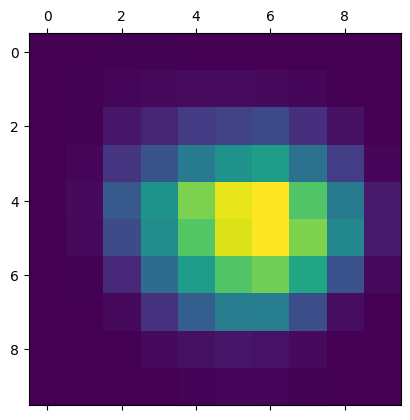

In [52]:
# Heatmap post-processing

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [53]:
# Superimposing the heatmap on the original picture

import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "cat.jpg"
superimposed_img.save(save_path)

<ipython-input-53-c94a8923eff4>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


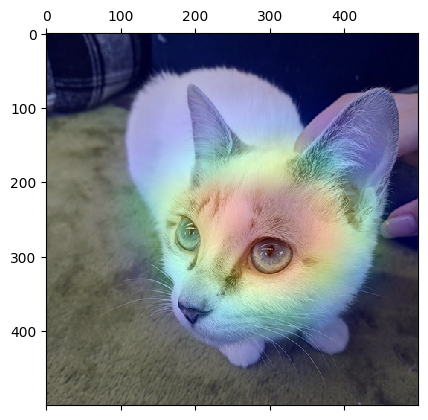

In [54]:
plt.matshow(superimposed_img)

Let's see more gradCAM results

Some good readings:
* [blog](https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353#:~:text=Gradient%2Dweighted%20Class%20Activation%20Mapping,regions%20in%20the%20image%20for) 

## Self-Practice Problem:
Solve an image classification problem on the cats-vs-dogs dataset by training 'mini-Exception-like' model based on the instructions given below:


1.  Set the global random seed to 42. 
2.  We are using a **cat-vs-dogs** dataset here. You will have to download it using instruction. 

  Download the data through the following command in your notebook

`!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/cats_vs_dogs_small.zip`

`!unzip -qq '/content/cats_vs_dogs_small.zip'`

  Use the  image_dataset_from_directory utility from tensorflow.keras.utils to make appropriate datasets. (0)
3.  Building the Model based on this [model_summary](https://indianinstituteofscience-my.sharepoint.com/:t:/g/personal/rohitc1_iisc_ac_in/EZ36t8eQFu9MrBnPjwueKcABD-2_8AZyDpyJ3vJEqUqlLQ?e=njNCGf) and its corresponding [model_plot](https://indianinstituteofscience-my.sharepoint.com/:i:/g/personal/rohitc1_iisc_ac_in/EU2WCnpqi8BEtfzltqI2vc4B5OFx53lMwn2tv6gqMebTig?e=lSsbz6). Ensure that you follow the trailing instructions:(16)

      i).   For the initial layers of model mentioned in this [summary](https://indianinstituteofscience-my.sharepoint.com/:i:/g/personal/ksumanth_iisc_ac_in/EYDi7MfYgkRGvb-NqKKuGiABon9CyOUMEiffHac1sXyEsg?e=gYNdVB), random flip (horizontal), random rotation of 0.1, random zoom of 0.2, rescaling by 1./255, and set kernel_size = 5 and use_bias=False in the convolution layer.

      ii).  Define a block of following layers:

          *   Batch Normalization layer 
          *   Activation layer with relu as activation function
          *   Depth wise separable layer (kernel size = 3)
          *   Batch Normalization layer 
          *   Activation layer with relu as activation function
          *   Depth wise separable layer (kernel size = 5)
          *   Batch Normalization layer 
          *   Activation layer with relu as activation function
          *   Depth wise separable layer (kernel size = 7)
          *   Maxpool2D layer (poolsize =3, stride=2)
          *   Convolution layer
          *   'Add layer' due to a residual connection. Infer connection points of the skip connection from the model summary and model plot.

          **Infer unspecified arguments from the summary**

      iii). The block defined in (ii) repeats 4 times. Note that in each repitition, the number of filters changes. Infer this from the model plot/summary.

      iv).  The last two layers are GlobalAveragePooling and Dense layers. The dense layer is the output layer (infer the number of neurons and the activation function).
4. Compile model with rmsprop as an optimizer with appropriate loss and metric for this respective problem.
5. Fit the model with a batch_size of 32 for 20 epochs. (Don't use EarlyStopping callback). Use the validation dataset from the data you downloaded. We have specified a small no. of epochs because training may take time. Try running colab on GPU by going to Edit > Notebook accelerator > Hardware Accelerator > GPU.
6. Return the history as a DataFrame. Show loss and accuracy for training and validation through appropriate plots.
7. Evaluate the Model on test dataset from the data you downloaded.

**Note**: 

1. If you are using any parameter values or arguments apart from the ones mentioned or the ones that you must infer, state explicitly where and why you are using them. 

2. Also verify that the total no. of params of your model are the same as that mentioned in model_summary txt file given to you
